In [1]:
from collections import OrderedDict
import glob
import matplotlib as mpl
import matplotlib.colors 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy.optimize as spopt
import scipy.stats as spstats

import populationevolution as popev

np.random.seed(42)
plt.style.use(('C:\\Users\\Nicholas Sherer\\.matplotlib\\Sherer_Thesis.mplstyle'))
%matplotlib inline

In [2]:
drift_runs = OrderedDict()
Ks = [200, 400, 800, 1600, 3200, 6400, 12800, 25600]
for K in Ks:
    drift_runs[K]=[]
for K in Ks:
    for file in glob.glob('drift_barrierK'+str(K)+'replicate?datetime.datetime(2019, 6, *).hdf5'):
        try:
            pop_reader = popev.PopulationReader(file)
            if len(pop_reader)==10**7: # filter out runs of different length so we can average over runs
                drift_runs[K].append(pop_reader)
        except OSError:
            pass

In [3]:
for K, sset in drift_runs.items():
    print(K, len(sset))

200 19
400 18
800 16
1600 14
3200 20
6400 20
12800 17
25600 17


In [4]:
def params_string(run):
    delta_f = run.delta_fitness
    M = run.mu_multiple
    p_b = run.fraction_beneficial
    p_a = run.fraction_accurate
    P_mu = run.fraction_mu2mu
    K = run.pop_cap
    s = 'delta_f: {}, M: {}, p_b: {}, p_a: {}, P_mu: {}, K: {}'.format(delta_f, M, p_b, p_a, P_mu, K)
    return s

print(params_string(drift_runs[200][5]))

delta_f: 0.1, M: 2, p_b: 0, p_a: 0.0038910505836575876, P_mu: 0.3, K: 200


In [5]:
cd Thesis_Data_and_Figures/

E:\Documents\Python Evolution Simulation\Population Evolution Project Source Code\Thesis_Data_and_Figures


In [6]:
mu_modes = OrderedDict()
mu_mins = OrderedDict()
f_modes = OrderedDict()
f_maxes = OrderedDict()
for K in Ks:
    mu_modes[K]=[]
    mu_mins[K]=[]
    f_modes[K]=[]
    f_maxes[K]=[]
for K in Ks:
    for run in drift_runs[K]:
        mu_modes[K].append(run.mode_mutation_rate)
        mu_mins[K].append(run.min_mutation_rate)
        f_modes[K].append(run.mode_fitness)
        f_maxes[K].append(run.max_fitness)

In [7]:
def plot_mu_trajectory(ax, mu_of_t):
    ax.semilogy(mu_of_t, marker='')
    ax.minorticks_off();
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());
    ax.set_yticks(np.unique(mu_of_t));

# Plots of the mode of the mutation rate over time

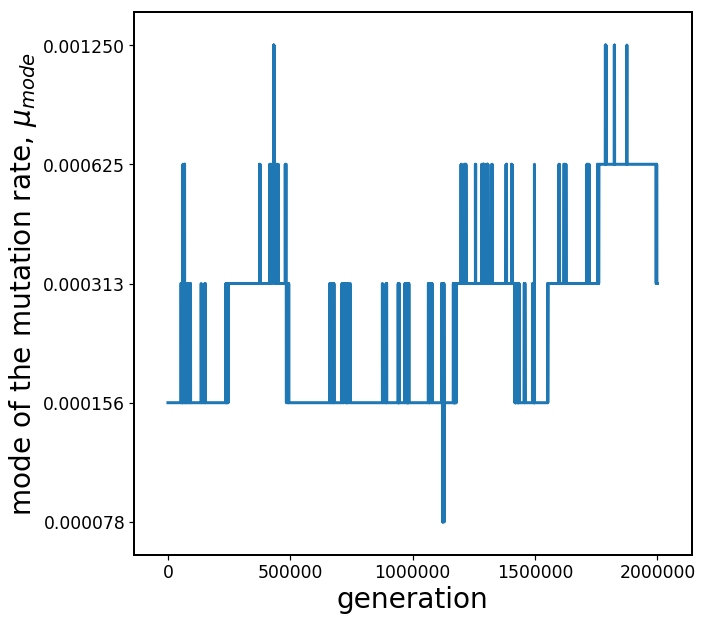

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_mu_trajectory(ax, mu_modes[25600][0][:2*10**6])
ax.set_xlabel('generation', fontsize=28);
ax.set_ylabel('mode of the mutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('mu_mode_trajectoryK25600.pdf')

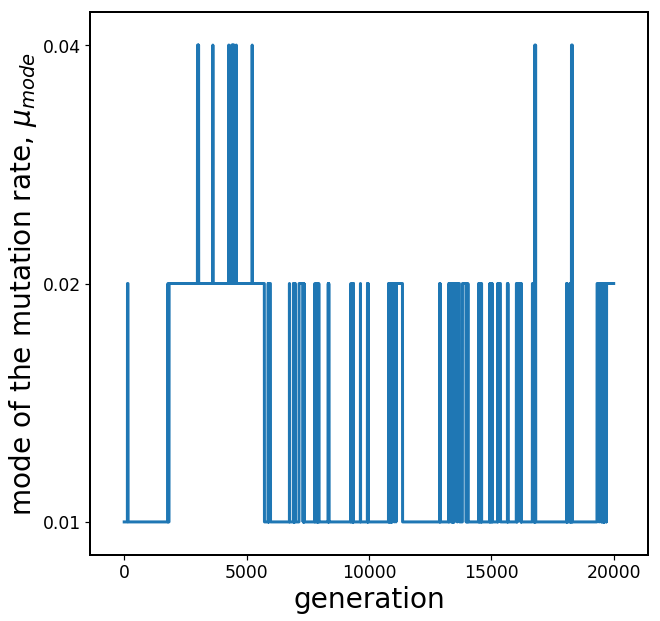

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_mu_trajectory(ax, mu_modes[400][0][:2*10**4])
ax.set_xlabel('generation', fontsize=28);
ax.set_ylabel('mode of the mutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('mu_mode_trajectoryK400.pdf')

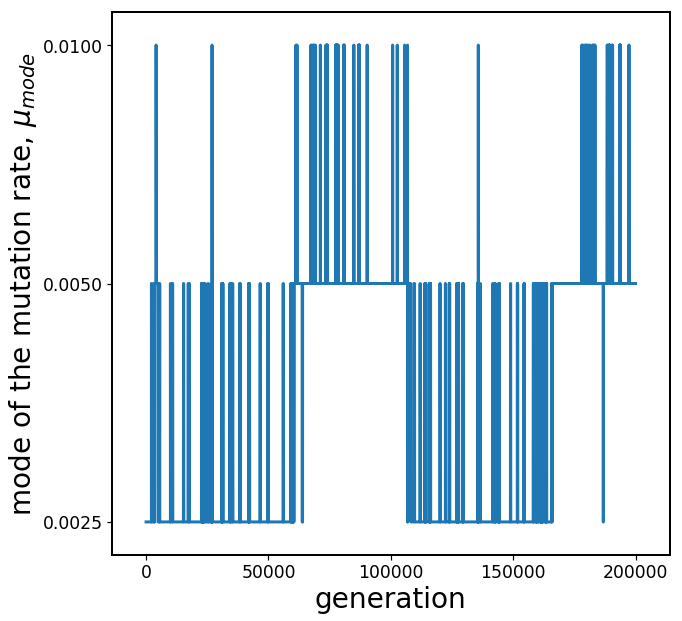

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_mu_trajectory(ax, mu_modes[1600][0][:2*10**5])
ax.set_xlabel('generation', fontsize=28);
ax.set_ylabel('mode of the mutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('mu_mode_trajectoryK1600.pdf')

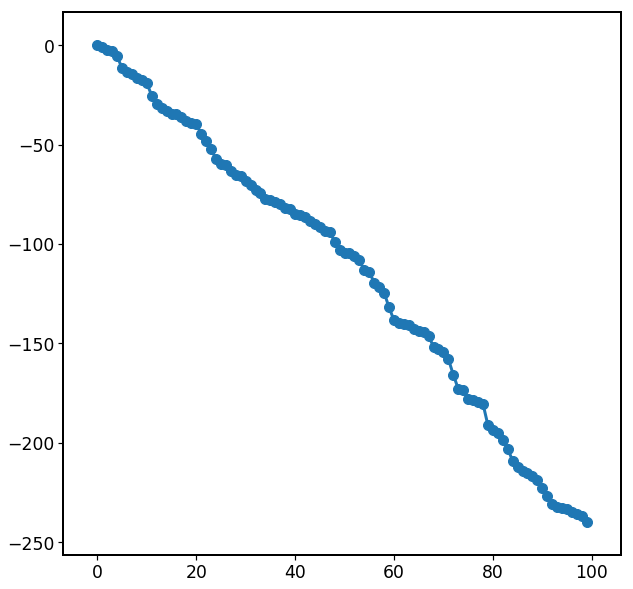

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(f_maxes[200][1][::100000])

# The distribution of mutation rate modes as a function of population size

In [12]:
def mus_to_mudist(mus):
    mus_v = np.unique(mus)
    mudist = np.zeros_like(mus_v,dtype='int64')
    for i, mu in enumerate(mus_v):
        mudist[i] = np.sum(mus==mu)
    return mus_v, mudist/np.sum(mudist)

def mean_mode_mu(mus_v, mudist):
    return np.sum(mus_v*mudist)

In [13]:
mu_dists = OrderedDict()
for K in Ks:
    mu_dists[K]=[]
    for mu_mode in mu_modes[K]:
        mu_dists[K].append(mus_to_mudist(mu_mode[:]))

In [14]:
def mean_std_mu_dists(mu_dists):
    mu_dists_s = []
    for mu_dist in  mu_dists:
        mu_dists_s.append(pd.Series(mu_dist[1], mu_dist[0]))
    N = len(mu_dists_s)
    whole_index = mu_dists_s[0].index
    for i in range(1, N):
        whole_index = whole_index.union(mu_dists_s[i].index)
    for i in range(1, N):
        mu_dists_s[i]=(mu_dists_s[i]).reindex(index=whole_index, fill_value=0)
    mu_dist_total = 0
    mu_dist_total2 = 0
    for mu_dist in mu_dists_s:
        mu_dist_total = mu_dist_total + mu_dist
        mu_dist_total2 = mu_dist_total2 + mu_dist**2
    mean_mu_dist = mu_dist_total/N
    mean_squared_mu_dist = mu_dist_total2/N
    std_mu_dist = np.sqrt(mean_squared_mu_dist - mean_mu_dist**2)
    return mean_mu_dist.dropna(), std_mu_dist.dropna()/np.sqrt(N)

In [15]:
def bar_plot_mudist(ax, mudist_m, mudist_std):
    mus_v = mudist_m.index
    prob = mudist_m.values
    yerr = mudist_std.values
    ind = np.arange(mus_v.size)
    ax.bar(ind, prob, yerr=yerr)
    ax.set_xticks(ind);
    ax.set_xticklabels(['{:.2g}'.format(mu) for mu in mus_v], rotation=0);

I need to remove the runs where the distribution of mutations got screwed up because the whole population had a mutation rate of 1.

In [16]:
for mud in mu_dists[200]:
    print(mud[0])

[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.00390625 0.005      0.0078125  0.01       0.015625   0.02
 0.03125    0.04       0.0625     0.08       0.125      0.16
 0.25       0.32       0.5        0.64       1.        ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.00390625 0.005      0.0078125  0.01       0.015625   0.02
 0.03125    0.04       0.0625     0.08       0.125      0.16
 0.25       0.32       0.5        0.64       1.        ]
[0.00390625 0.005      0.0078125  0.01       0.015625   0.02
 0.03125    0.04       0.0625     0.08       0.125      0.16
 0.25       0.32       0.5        0.64       1.        ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]
[0.005 0.01  0.

In [17]:
for mud in mu_dists[400]:
    print(mud[0])

[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.00125 0.0025  0.005   0.01    0.02    0.04    0.08    0.16   ]
[0.0025 0.005  0.01   0.02   0.04   0.08  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08  ]
[0.0025 0.005  0.01   0.02   0.04   0.08  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08  ]
[0.00125 0.0025  0.005   0.01    0.02    0.04    0.08    0.16   ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]
[0.0025 0.005  0.01   0.02   0.04   0.08   0.16  ]


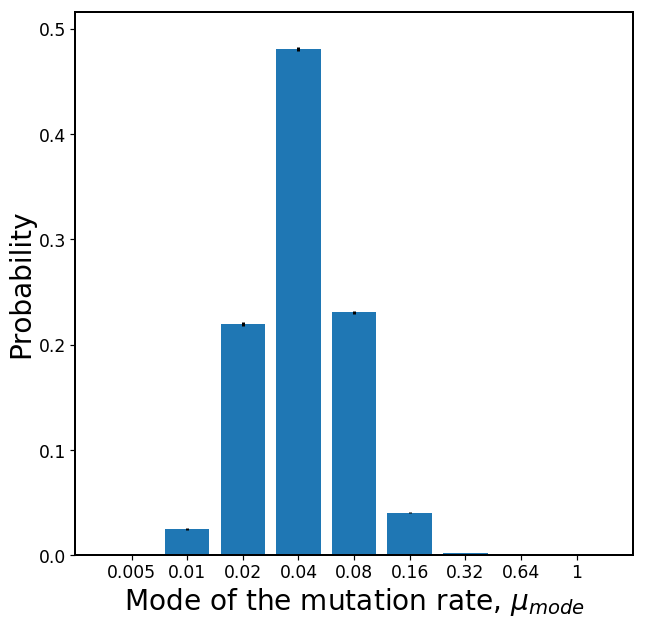

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
bar_plot_mudist(ax, *mean_std_mu_dists([mu_dists[200][i] for i in [0,2,5,6,7,8,9,10,11,13,14,16,17]]))
ax.set_xlabel('Mode of the mutation rate, $\mu_{mode}$', fontsize=28)
ax.set_ylabel('Probability', fontsize=28)
plt.savefig('db_mu_mode_distK200.pdf')

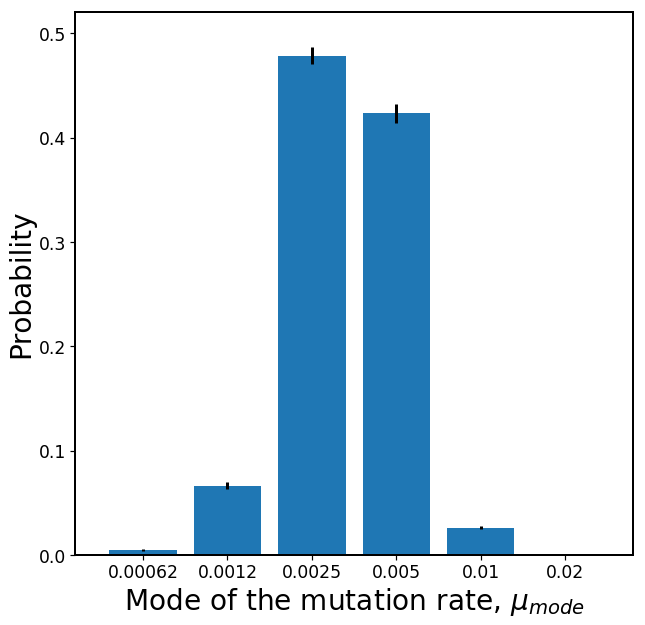

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
bar_plot_mudist(ax, *mean_std_mu_dists(mu_dists[1600]))
ax.set_xlabel('Mode of the mutation rate, $\mu_{mode}$', fontsize=28)
ax.set_ylabel('Probability', fontsize=28)
plt.savefig('db_mu_mode_distK1600.pdf')

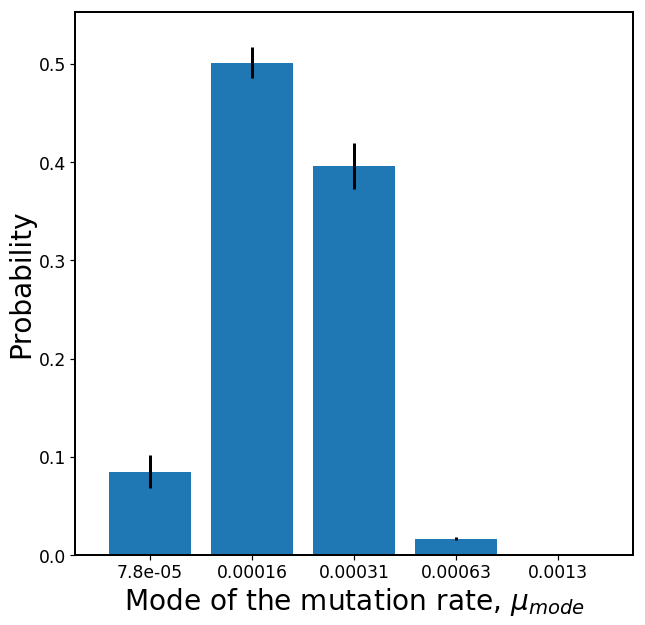

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
bar_plot_mudist(ax, *mean_std_mu_dists(mu_dists[25600]))
ax.set_xlabel('Mode of the mutation rate, $\mu_{mode}$', fontsize=28)
ax.set_ylabel('Probability', fontsize=28)
plt.savefig('db_mu_mode_distK25600.pdf')

# The mode of the mode of the mutation rate as a function of population size

To better show what's going on, I'll instead plot the empirical distribution of the dominant mutation rate for each population size. I've adjusted the axis labels manually because adjusting all the bar widths and plotting on the log scale and then attempting to rescale is hard to get looking right, manually inserting the correct labels is the easiest way I've figured out how to do things.

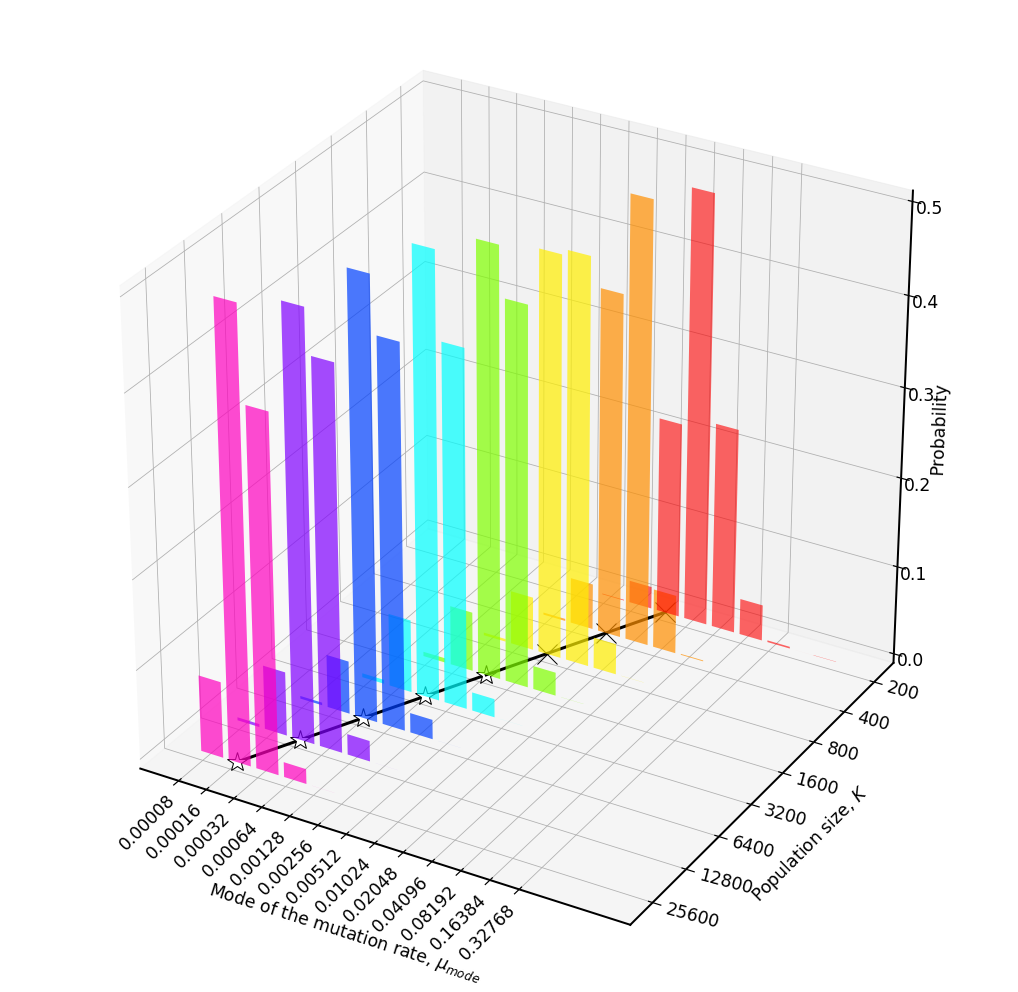

In [21]:
fig = plt.figure(figsize=(18,18));
ax = fig.add_subplot(111, projection='3d');

ys, yerss = mean_std_mu_dists([mu_dists[200][i] for i in [0,2,5,6,7,8,9,10,11,13,14,16,17]])
xs = np.log2(ys.index)
ax.bar(xs,  ys, zs=10, zdir='y', alpha=.6, color=matplotlib.colors.hsv_to_rgb(np.array([0,1,1])));
colors = [matplotlib.colors.hsv_to_rgb(np.array([x,1,1])) for x in [3/32, 5/32, 8/32, 16/32, 20/32, 24/32, 28/32]]

for i, K in enumerate(Ks[1:]):
    ys, yerrs = mean_std_mu_dists(mu_dists[K])
    xs = np.log2(ys.index)
    ax.bar(xs,  ys, zs=-i*10, zdir='y', alpha=.7, color = colors[i]);
ax.set_xlabel('Mode of the mutation rate, $\mu_{mode}$ ', labelpad=40);
ax.set_ylabel('Population size, $K$', labelpad=25);
ax.set_zlabel('Probability');
ax.set_yticklabels([25600, 12800, 6400, 3200, 1600, 800, 400, 200],
                   rotation=-15, rotation_mode='anchor', ha='left', va='bottom');
ax.set_xticks(list(range(-14,-1)));
ax.set_xticklabels(['{:6.5f}'.format(i) for i in .00008*2**np.arange(14)],
                   rotation=45, rotation_mode='anchor', ha='right', va='center');
ax.plot3D(np.arange(-13,-8)+.25,10*np.arange(-6,-1),np.zeros(5), color='k',
          marker='*', markersize=20, markerfacecolor='white')
ax.plot3D(np.arange(-9,-7)+.25,10*np.arange(-2,0),np.zeros(2), color='k', marker='')
ax.plot3D(np.arange(-8,-5)+.25,10*np.arange(-1,2),np.zeros(3), color='k', marker='x', markersize=20)
plt.savefig('drift_barrier_scaling.pdf')

# The mutation rate landscape catastrophe

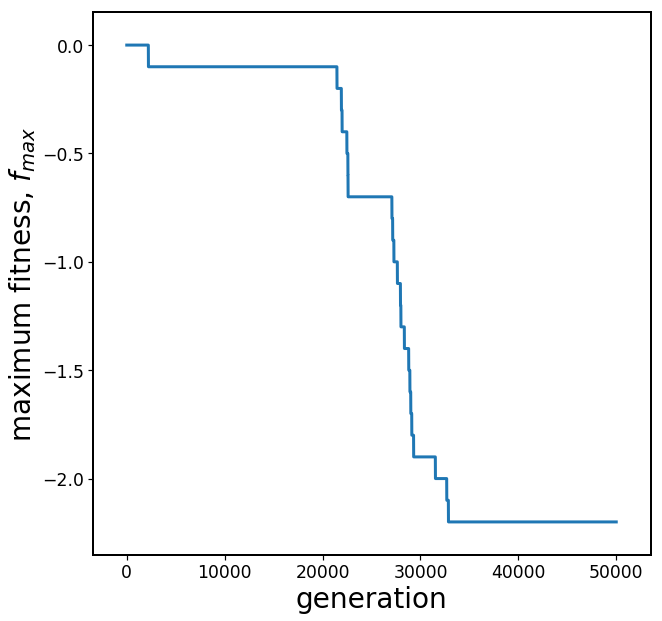

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(f_maxes[200][0][:5*10**4],marker='')
ax.set_xlabel('generation', fontsize=28)
ax.set_ylabel('maximum fitness, $f_{max}$', fontsize=28);
plt.savefig('fitness_catastrophe.pdf')

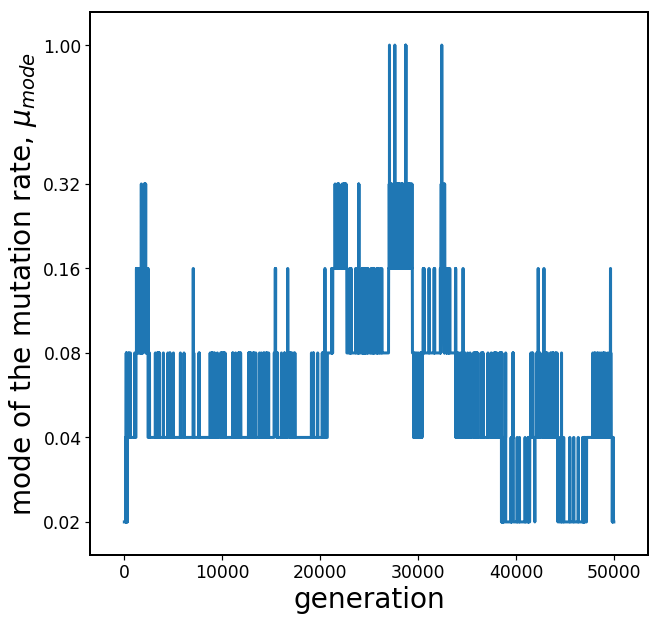

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_mu_trajectory(ax, mu_modes[200][0][:5*10**4])
ax.set_xlabel('generation', fontsize=28);
ax.set_ylabel('mode of the mutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('mutation_rate_during_catastrophe.pdf')

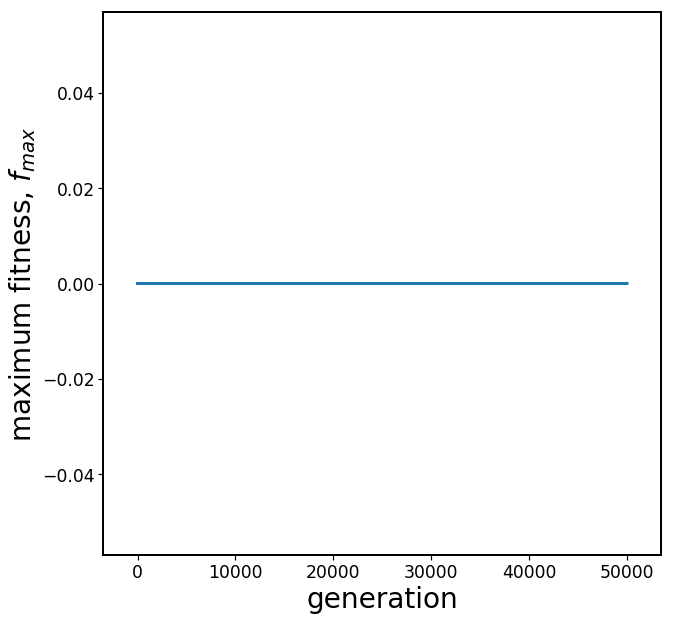

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(f_maxes[400][0][:5*10**4],marker='')
ax.set_xlabel('generation', fontsize=28)
ax.set_ylabel('maximum fitness, $f_{max}$', fontsize=28);
plt.savefig('fitness_not_catastrophe.pdf')

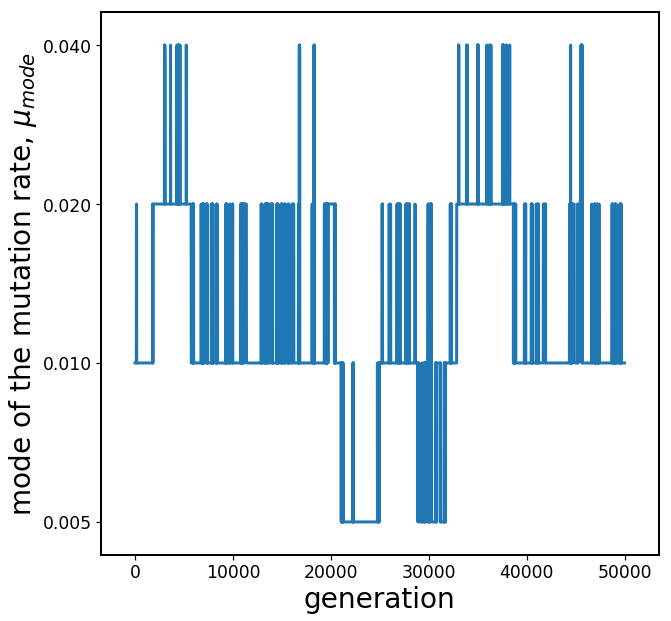

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_mu_trajectory(ax, mu_modes[400][0][:5*10**4])
ax.set_xlabel('generation', fontsize=28);
ax.set_ylabel('mode of the mutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('mutation_rate_not_catastrophe.pdf')